# Summer HgXe Lamp 2025 CMZ Analysis Part 1/2

## <span style="color: red;">Spoiler Alert: No discernable signals, even to FTs.</span>

Goal: Find the signals from the images and take FFTs.

Files Needed: The png image files, the png dark files if you're using them (if they exist).

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib.animation import ArtistAnimation
import uncertainties as u
from scipy.optimize import curve_fit
from uncertainties import unumpy as unp
from IPython.display import clear_output

#### Get important image parameters.

During one "Stay", the camera takes one image. Between stays, the motor moves once by distPerStay. The motor is in place for approximately stayTime + t_exp, but there may be some overlap because the measurement fortunately took less time to run than expected. It doesn't matter, because we keep track of displacements, not times.

In [2]:
### images aren't part of the signal.
numStays1 = 6000 #number of images taken while the 1st motor moved
numStays2 = 2 #ditto for the 2nd motor
numStays_pause = 10 #number of pauses before, between, after the two motors
stayTime = 1.8 #s
distPerStay = 2.5 #um. motor movement distance per image

t_exp = 0.3 #s
imgsize_y = 3672 #in this convention, y is vertical and spatial arrays are stored (y,x)
imgsize_x = 5496 

#for if your dataset includes darks and/or flats.
use_darks = False
#flats = False #flat correction not currently implemented. Probably only necessary for a different setup than ours.

displacements = distPerStay*np.array([i for i in range(numStays1+numStays2)]) #um (as in microns). The places the motors were during images

#### Display an image to find subset image regions to use.

Each one of these images is over 20 million pixels, so we want to avoid doing any unnecessary computation on regions we're not going to use.

In [9]:
%matplotlib widget
#Widget is nice because it allows you to zoom in arbitrarily anywhere on images without running any more code, but 
# it also warns you about memory after 20 images and doesn't save nicely for displaying on, for example, github.
# Also, it applies the effect to ALL graphs.

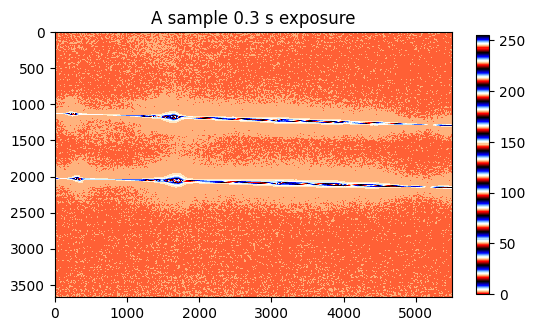

In [3]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(Image.open("C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_HgXe_img199.png")),
         cmap='flag')
ax.set_title(f'A sample {t_exp} s exposure')
colorbar = fig.colorbar(im, ax=ax, shrink = 0.7)

Create an average of many exposures, hopefully making spots visible.

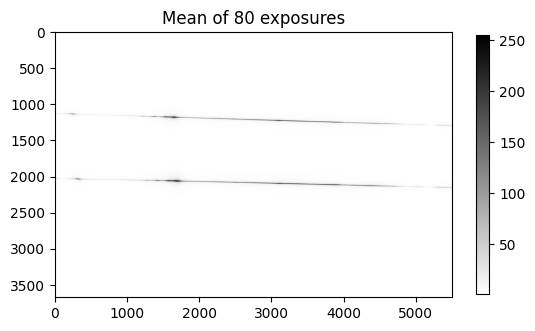

In [4]:
fig, ax = plt.subplots()
avg_img = np.zeros((imgsize_y,imgsize_x))
for imgn in range(4000, 4080):
    avg_img += np.array(Image.open(f"C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_HgXe_img{imgn}.png"))
avg_img *= 1./80.
im = ax.imshow(avg_img, cmap='binary')
ax.set_title(f'Mean of {85-5} exposures')
colorbar = fig.colorbar(im, ax=ax, shrink = 0.7)

Now for a more sensitive colormap of the above. See how uniform the background is!

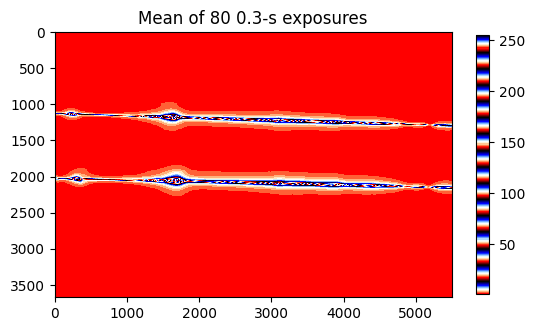

In [5]:
fig, ax = plt.subplots()
im = ax.imshow(avg_img, cmap='flag')
ax.set_title(f'Mean of {80} {t_exp}-s exposures')
colorbar = fig.colorbar(im, ax=ax, shrink = 0.7)

#### Set image paths and spot locations and initialize the spot_df dataframe.

In [8]:
#This is why we have matplotlib widget. Set one-pixel-wide columns.
#select y and x centers of each region, then select borders based on that.
skip_n = 100 #only include every skip_n columns, just for time's sake. 
xc = np.array([x for x in range(1,imgsize_x,skip_n)])
yc1 = np.rint([1135+((1304-1135)/imgsize_x)*x for x in range(1,imgsize_x,skip_n)]) #rint to round them to integers
yc2 = np.rint([2035+((2162-2035)/imgsize_x)*x for x in range(1,imgsize_x,skip_n)])

spot_radius = 25 #pixels

#uncertainty-calculating region. Uncertainties will be called "unc" in variable names.
ux0 = 2000
uxf = 3000
uy0 = 1540
uyf = 1560

img_pathname = "C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_HgXe_img"
#dark_pathname = 

spot_df = [] #initialize the array. We're gonna store everything about each spot in this soon-to-be dataframe.

for i in range(len(xc)): 
    spot_df.append([1, xc[i], yc1[i]])
    spot_df.append([2, xc[i], yc2[i]])

spot_df = pd.DataFrame(spot_df, columns=['output', 'x_center', 'y_center'])

display_colors = ['#000000'] * len(xc)

# Duplicating colors above for assignment of both outputs
display_colors_duplicated = []
for color in display_colors:
    display_colors_duplicated.append(color)
    display_colors_duplicated.append(color)

spot_df['display_color'] = display_colors_duplicated

spot_df

,output,x_center,y_center,display_color
0,1,1,1135.0,#000000
1,2,1,2035.0,#000000
2,1,101,1138.0,#000000
3,2,101,2037.0,#000000
4,1,201,1141.0,#000000
...,...,...,...,...
105,2,5201,2155.0,#000000
106,1,5301,1298.0,#000000
107,2,5301,2157.0,#000000
108,1,5401,1301.0,#000000


#### Plot the locations of the spot/unc regions and try to identify wavelengths

The big one in the middle is the region we use to identify uncertainty.

As can be seen when zoomed in, it'd probably be a better signal if we made the spot radius some function of x. But if we see no signal at all and can't fit and the FT is garbage, making a line 20 percent wider isn't going to save us and give us the path length.

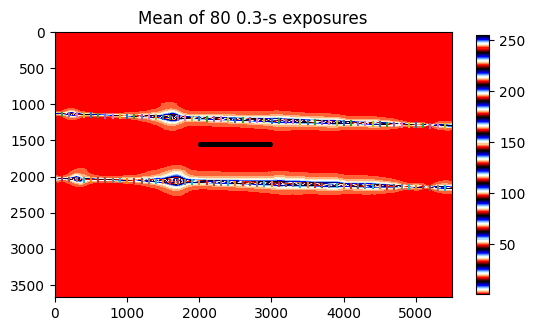

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(avg_img, cmap='flag')
ax.set_title(f'Mean of {85-5} {t_exp}-s exposures')
colorbar = fig.colorbar(im, ax=ax, shrink = 0.7)

#Plot boxes for the wavelenth spots. Use widget to check.
for i, spot in spot_df.iterrows():
    ax.plot([spot['x_center'],spot['x_center']],[spot['y_center']-spot_radius,spot['y_center']+spot_radius])
    unc_patch = matplotlib.patches.Polygon([[ux0,uy0],[ux0,uyf],[uxf,uyf],[uxf,uy0]],fill=False)
    ax.add_patch(unc_patch)

#### Play an animation of a subset of the images. This part's optional but it looks pretty. Epilepsy warning (dim backgrounds flip between colors).

In [22]:
def animate_mz(frames, name_specifier=None, cmap='flag', title=None, interval=100, save=False):
    
    fig, ax = plt.subplots()

    #create the artist list and animation
    imgs = []
    for i, frame in enumerate(frames): 
        img = ax.imshow(frame,origin='lower',cmap=cmap,animated=True)
        imgs.append([img])
    ani = ArtistAnimation(fig, imgs, interval=interval, blit=False, repeat_delay=0)

    if save:
        ani.save(f"mz_ASI183_{name_specifier}.gif")
        
    return ani

In [23]:
#%matplotlib widget #You can also zoom in on animations

In [ ]:
animation_imgn_start = 5
animation_imgn_end = 50

img_pathname = "C:/Users/tdavd/Desktop/Quantum Astrometry/SharpCap Captures/mz_astrocam_HgXe_img"
#dark_pathname = 

sample_frames = []
for n in range(animation_imgn_start, animation_imgn_end):
    sample_frames.append(np.array(Image.open(img_pathname + f"{n}.png")))

animate_mz(sample_frames, "mz_ASI183_HgXe_flag", cmap='flag', save=True)

#### Turn PNGs into signals.

Skip the regions enclosed by |=== and ===| if you have already saved hist_vals and unc_vals!

#### |============================================================================

#### Make smaller 2D arrays w/ dimensions of (imgn, y) out of each spot (column segment) in each image and the uncertainty region. Also subtract darks if you want.

To make sure we don't run out of memory, let's do the following steps in chunks. 

This function's length is in part due to the if statements for whether to use dark frames. I don't think this is slowing its execution down too much, though.

Regarding uncertainty, we assume the background fluctuations are the main source of uncertainty. To account for them in an image, take the mean and std. dev. of the unc region. Assume this is the mean and uncertainty in one pixel's value. In a spot with $N$ pixels, each of which has a background value $v=\mu\pm\sigma$, the sum of N of these random variables is $N\mu\pm\sqrt{N}\sigma$ since uncertainties add in quadrature (not to be confused with N times v, which includes only one random variable and has a greater uncertainty $N\sigma$). We also subtract the background mean times N from the signals, to account for changes in background brightness.

Make sure not to confuse labels for the 2D uncertainty region array with arrays representing the uncertainties in the signal points, which are (number of signals) 1D arrays made only in the final steps. The uncertainty region is typically handled on its own after a loop containing all the other regions. As a result, a few blocks look like this:

for spot in spots:

    do stuff to spot.
    
do stuff to unc region

In [10]:
def calculate_signal():
    #initialize structure of final arrays. The structure is [[signal 1 array],...,[signal N array]]
    unc_arrays = []
    signal_arrays = []
    for i in range(len(spot_df)):
        unc_arrays.append([])
        signal_arrays.append([])

    #start iterating over chunks
    num_chunks = (numStays1+numStays2) // 100 #chunk size of 100 assumed
    for chunk_index in range(num_chunks):

        #Define the signal regions
        spot_2d_img_arrays = [] #1-2-1-2 order
        if use_darks:
            spot_2d_dark_arrays = []
        for i, spot in spot_df.iterrows():
            spot_2d_img_arrays.append(np.zeros((100,2*spot_radius),dtype=np.float32))
            if use_darks:
                spot_2d_dark_arrays.append(np.zeros((100,2*spot_radius),dtype=np.float32))
        #Ditto for the uncertainty region
        unc_3d_img_array = np.zeros((100,(uyf-uy0),(uxf-ux0)),dtype=np.float32) 
        if use_darks:
            unc_3d_dark_array = np.zeros((100,(uyf-uy0),(uxf-ux0)),dtype=np.float32)
        
        #make the 3d arrays (dims are (,,))
        back_pixel_vals = []
        back_pixel_uncs = []
        for j in range(100):
            imgn = j + 1 + 100*chunk_index

            if use_darks:
                #make arrays out of entire PNGs.
                img_array_2d = np.array(Image.open(img_pathname + f'{imgn}.png'), dtype=np.float32)
                dark_array_2d = np.array(Image.open(dark_pathname + f'{imgn}.png'), dtype=np.float32)
                for i, spot in spot_df.iterrows(): #FIXME: just take advantage of the tuple structure of spot_df.iterrows()...
                    spot_2d_img_arrays[i][j-1,:] = img_array_2d[int(spot['y_center']-spot_radius):int(spot['y_center']+spot_radius),int(spot['x_center'])]
                    spot_2d_dark_arrays[i][j-1,:] = dark_array_2d[int(spot['y_center']-spot_radius):int(spot['y_center']+spot_radius),int(spot['x_center'])]
                unc_3d_img_array[j-1,:,:] = img_array_2d[uy0:uyf,ux0:uxf]
                unc_3d_dark_array[j-1,:,:] = dark_array_2d[uy0:uyf,ux0:uxf]
                #calculate arrays representing subsets of the full master dark in the spot regions
                master_dark_spots = []
                for dark_series in spot_3d_dark_arrays:
                    master_dark_spots.append(np.median(dark_series, 0))
                #dark-subtract, changing values in spot_3d_img_arrays
                for i, spot_tuple in enumerate(list(spot_df.iterrows())):
                    for img_arr in spot_3d_img_arrays[i]:
                        img_arr -= master_dark_spots[i]
                #Ditto for uncertainty region:
                master_dark_unc = np.median(unc_3d_dark_array, 0) #median along the image index axis
                for img_arr in unc_3d_img_array:
                    img_arr -= master_dark_unc

            else: #less to do if there's no darks.
                #make an array out of one entire PNG.
                img_array_2d = np.array(Image.open(img_pathname + f'{imgn}.png'), dtype=np.float32)
                #create the 100 x Nx x Ny spot arrays
                for i, spot in spot_df.iterrows():
                    spot_2d_img_arrays[i][j-1,:] = img_array_2d[int(spot['y_center']-spot_radius):int(spot['y_center']+spot_radius),int(spot['x_center'])]
                unc_3d_img_array[j-1,:,:] = img_array_2d[uy0:uyf,ux0:uxf]
                
        #calculate background means, stdevs
        back_pixel_vals = np.mean(unc_3d_img_array, (1,2))
        back_pixel_uncs = np.std(unc_3d_img_array, (1,2))

        #create the final chunk signal and uncertainty arrays from the 3d arrays and append them to the total
        for i, spot_2d_img_array in enumerate(spot_2d_img_arrays):
            spot_pixels = spot_2d_img_array[0].size
            chunk_signal_array = np.sum(spot_2d_img_array, 1) - spot_pixels*np.array(back_pixel_vals)
            chunk_unc_array = np.sqrt(spot_pixels)*np.array(back_pixel_uncs)
            
            for signal_pt, unc_pt in zip(chunk_signal_array, chunk_unc_array):
                signal_arrays[i].append(signal_pt)
                unc_arrays[i].append(unc_pt)

        clear_output()
        print(f"Chunk {1+chunk_index}/{num_chunks} finished.")

    return signal_arrays, unc_arrays
    
#takes about 20s per 100 images.

In [11]:
signal_arrays, unc_arrays = calculate_signal()

spot_df['hist_vals'] = signal_arrays
spot_df['unc_vals'] = unc_arrays
spot_df

Chunk 60/60 finished.


,output,x_center,y_center,display_color,hist_vals,unc_vals
0,1,1,1135.0,#000000,"[49.545, 46.5075, 41.46, 47.6, 46.487503, 48.5...","[0.7342066884801581, 0.7122842159614592, 0.675..."
1,2,1,2035.0,#000000,"[108.545, 113.5075, 110.46, 111.6, 111.4875, 1...","[0.7342066884801581, 0.7122842159614592, 0.675..."
2,1,101,1138.0,#000000,"[54.545, 47.5075, 53.46, 54.6, 50.487503, 52.5...","[0.7342066884801581, 0.7122842159614592, 0.675..."
3,2,101,2037.0,#000000,"[43.545, 44.5075, 44.46, 43.6, 46.487503, 42.5...","[0.7342066884801581, 0.7122842159614592, 0.675..."
4,1,201,1141.0,#000000,"[308.54498, 300.5075, 300.46, 299.6, 298.4875,...","[0.7342066884801581, 0.7122842159614592, 0.675..."
...,...,...,...,...,...,...
105,2,5201,2155.0,#000000,"[35.545, 31.5075, 31.46, 28.599998, 34.487503,...","[0.7342066884801581, 0.7122842159614592, 0.675..."
106,1,5301,1298.0,#000000,"[125.545, 130.5075, 129.45999, 130.6, 128.4875...","[0.7342066884801581, 0.7122842159614592, 0.675..."
107,2,5301,2157.0,#000000,"[214.545, 223.5075, 219.45999, 223.6, 223.4875...","[0.7342066884801581, 0.7122842159614592, 0.675..."
108,1,5401,1301.0,#000000,"[184.545, 179.5075, 182.45999, 182.6, 185.4875...","[0.7342066884801581, 0.7122842159614592, 0.675..."


In [13]:
for i, spot in spot_df.iterrows():
    name = f"f25A_HgXe/ASI183_f25A_wavelength{1+i//2}_out{spot['output']}"
    file_name = name
    ufile_name = name + "_unc"
    np.save(file_name,spot_df.loc[i, 'hist_vals'])
    np.save(ufile_name,spot_df.loc[i, 'unc_vals'])

#### ============================================================================|

#### Load saved arrays and assign into spot_df.

In [9]:
# Loading previously made hist_val files into current notebook kernel
hist_vals = []
unc_vals = []
for i, spot in spot_df.iterrows():
    name = f"f25A_HgXe/ASI183_f25A_wavelength{1+i//2}_out{spot['output']}"
    file_name = name + ".npy"
    ufile_name = name + "_unc.npy"
    hist_vals.append(np.load(file_name))
    unc_vals.append(np.load(ufile_name))
        
spot_df['hist_vals'] = hist_vals
spot_df['unc_vals'] = unc_vals

spot_df

,output,x_start,y_start,x_end,y_end,display_color,exp wl,x_center,y_center,hist_vals,unc_vals
0,1,946,1151,980,1162,#000000,852.14411,963.0,1156.5,"[1215.0, 1192.0, 1162.0, 1049.0, 1019.0, 989.0...","[742.91376, 743.00854, 742.9374, 743.03204, 74..."
1,2,1210,2040,1230,2051,#000000,852.14411,1220.0,2045.5,"[950.0, 962.0, 1011.0, 992.0, 1028.0, 1065.0, ...","[437.00812, 437.06384, 437.02197, 437.07767, 4..."
2,1,1180,1158,1212,1169,#2ca02c,842.00000,1196.0,1163.5,"[1974.0, 1882.0, 1680.0, 1331.0, 1226.0, 1123....","[699.21295, 699.3021, 699.23517, 699.3243, 699..."
3,2,1445,2041,1472,2062,#2ca02c,842.00000,1458.5,2051.5,"[3475.0, 3604.0, 3882.0, 3895.0, 4037.0, 4215....","[1126.2891, 1126.4327, 1126.3248, 1126.4684, 1..."
4,1,1221,1160,1249,1169,#d62728,826.45215,1235.0,1164.5,"[1207.0, 1160.0, 1062.0, 891.0, 862.0, 818.0, ...","[500.57294, 500.63675, 500.5888, 500.6526, 500..."
5,2,1489,2044,1509,2063,#d62728,826.45215,1499.0,2053.5,"[2538.0, 2610.0, 2744.0, 2657.0, 2744.0, 2808....","[754.8322, 754.92847, 754.85614, 754.95233, 75..."
6,1,1570,1170,1599,1182,#9467bd,811.00000,1584.5,1176.0,"[1926.0, 1829.0, 1660.0, 1368.0, 1291.0, 1264....","[691.2674, 691.3555, 691.2893, 691.3774, 691.1..."
7,2,1844,2053,1868,2074,#9467bd,811.00000,1856.0,2063.5,"[4334.0, 4415.0, 4703.0, 4555.0, 4685.0, 4766....","[1001.1459, 1001.2735, 1001.1776, 1001.3052, 1..."
8,1,1933,1177,1965,1199,#ff7f0e,801.00000,1949.0,1188.0,"[11030.0, 11030.0, 10897.0, 9646.0, 9341.0, 88...","[1398.4259, 1398.6042, 1398.4703, 1398.6486, 1..."
9,2,2213,2059,2240,2086,#ff7f0e,801.00000,2226.5,2072.5,"[4406.0, 4416.0, 4645.0, 4930.0, 5418.0, 6076....","[1448.0859, 1448.2706, 1448.132, 1448.3164, 14..."


#### Graph *a few of* the created histograms. The name "histogram" is a relic of the Timepix analysis.

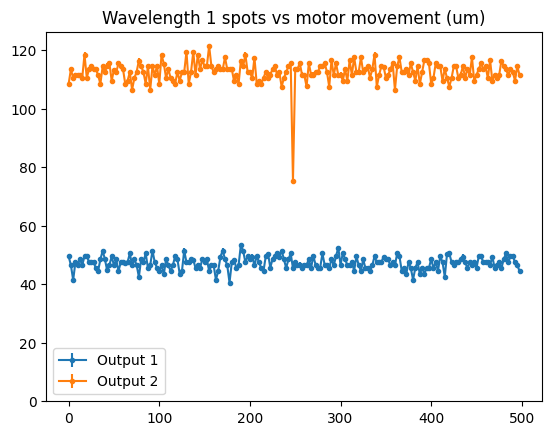

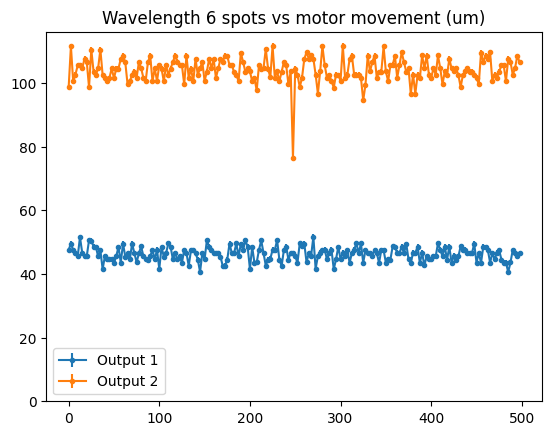

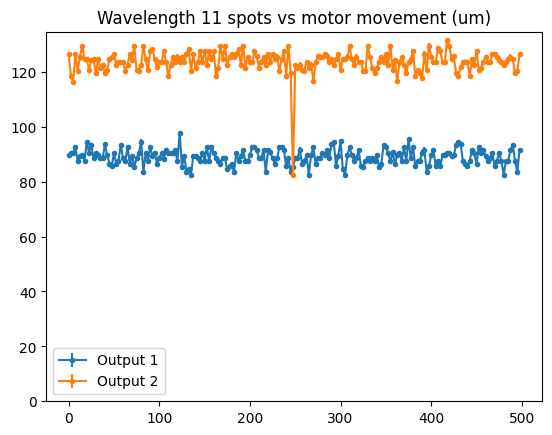

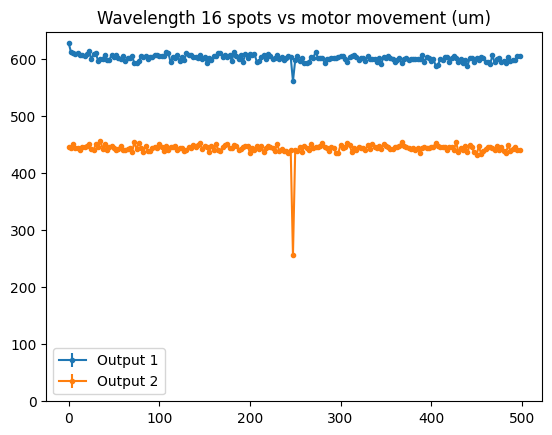

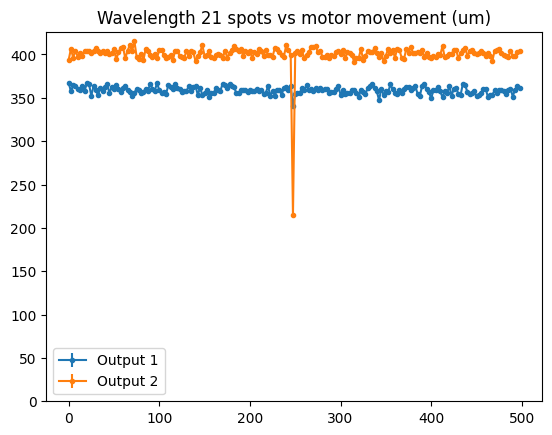

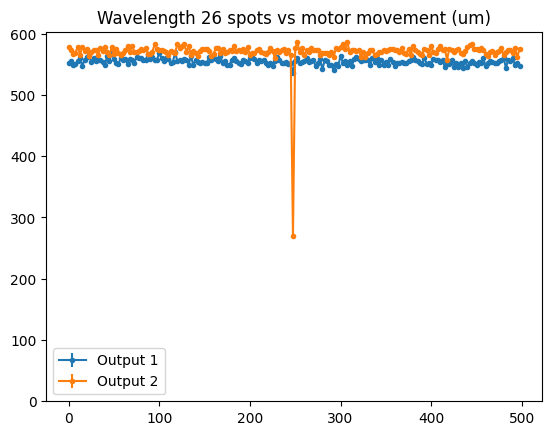

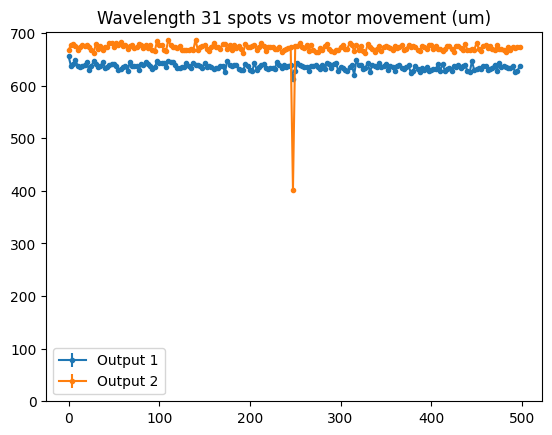

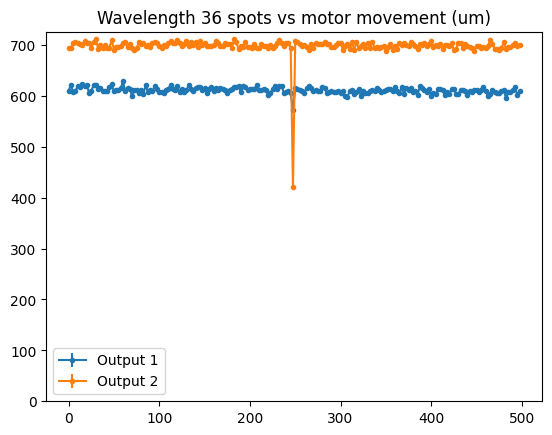

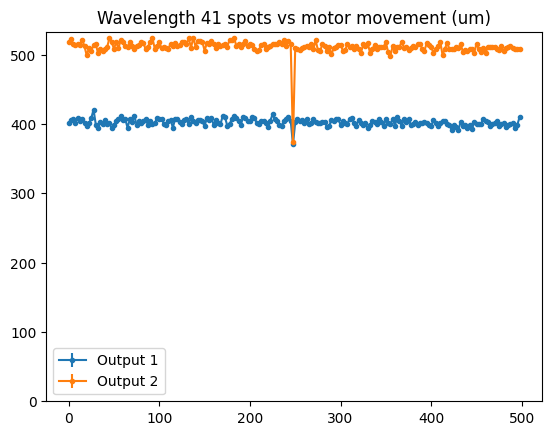

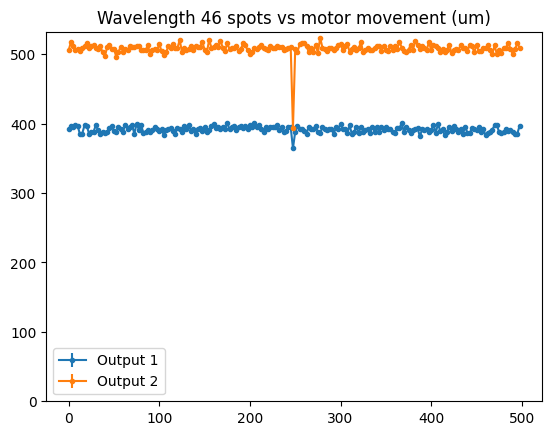

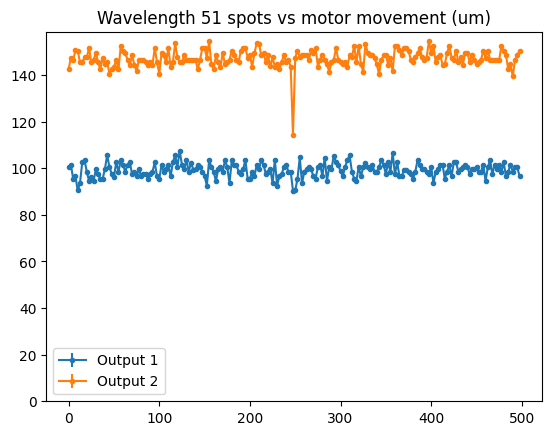

In [14]:
graph_skip_n = 5 #only graph every graph_skip_n signals of the ones already limited by skip_n.

p0 = 0
pf = 200


for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    if i == 1:
        print(output_1['hist_vals'])


    if i % graph_skip_n == 0:
        fig, ax = plt.subplots()
        
        ax.errorbar(displacements[p0:pf], output_1['hist_vals'][p0:pf], yerr=output_1['unc_vals'][p0:pf], marker='.', label=f"Output {output_1['output']}")
        ax.errorbar(displacements[p0:pf], output_2['hist_vals'][p0:pf], yerr=output_2['unc_vals'][p0:pf], marker='.', label=f"Output {output_2['output']}")

        ax.set_ylim(bottom=0)
    
        ax.set_title(f"Wavelength {1+i//2} spots vs motor movement (um)")
        ax.legend()

#### Calculate visibilities and their uncertainties.

In [15]:
#FIXME: it's giving me some negative values for uncertainty in visibility
#current solution: just use the absolute value

visibility_uarrays = []
for i, spot in spot_df.iloc[::2].iterrows():
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    output_1_uarray = unp.uarray(output_1['hist_vals'], output_1['unc_vals'])
    output_2_uarray = unp.uarray(output_2['hist_vals'], output_2['unc_vals']) 
    
    spot_visibility_uarray = (output_1_uarray - output_2_uarray) / (output_1_uarray + output_2_uarray)
    visibility_uarrays.append(spot_visibility_uarray)
    visibility_uarrays.append(spot_visibility_uarray)

vis_vals = []
vis_uncs = []
for vis_uarray in visibility_uarrays:
    vis_vals.append([])
    vis_uncs.append([])
    for val_unc in vis_uarray:
        vis_vals[-1].append(val_unc.n)
        vis_uncs[-1].append(val_unc.s)

spot_df['vis_vals'] = vis_vals
spot_df['vis_uncs'] = vis_uncs

#### ============================================================================

In [16]:
#save visibility data
for i, spot in spot_df.iloc[::2].iterrows():
    name = f"f25A_HgXe/ASI183_f25A_wavelength{1+i//2}_out{spot['output']}_vis"
    file_name = name
    ufile_name = name + "_unc"
    np.save(file_name,spot_df.loc[i, 'vis_vals'])
    np.save(ufile_name,spot_df.loc[i, 'vis_uncs'])

#### ============================================================================

#### RESOLVE: Do I need to get values for what wavelengths these points are at in order to fit? Do I at least need nontrivial estimates? Keep going until I am blocked by not having...

#### Fourier Analysis

In [20]:
#Limits on what part of signal to be analyzed (um)
model_start = 0.0
model_end = 6000*2.5

# Finding closest index in bin_centers_rt array to above values
start_index = np.argmin(np.abs(displacements-model_start))
end_index = np.argmin(np.abs(displacements-model_end))
model_size = end_index - start_index

print(f"The model will start at index {start_index} and end at {end_index} within the value arrays.")

The model will start at index 0 and end at 6000 within the value arrays.


In [21]:
# Creating fft values using np.fft.fft
frequencies = np.fft.fftfreq(model_size, displacements[1] - displacements[0])
fft_vals = []
fft_vis_vals = []

for i, spot in spot_df.iterrows():
    spot_fft = np.fft.fft(spot['hist_vals'][start_index:end_index])
    fft_vals.append(spot_fft)
    
    if i % 2 == 0:
        visibility_fft = np.fft.fft(spot['vis_vals'][start_index:end_index])
        fft_vis_vals.append(visibility_fft)
        fft_vis_vals.append(visibility_fft)
        
spot_df['fft_vals'] = fft_vals
spot_df['fft_vis_vals'] = fft_vis_vals

#### Signal Fourier transforms

In [22]:
#%matplotlib widget

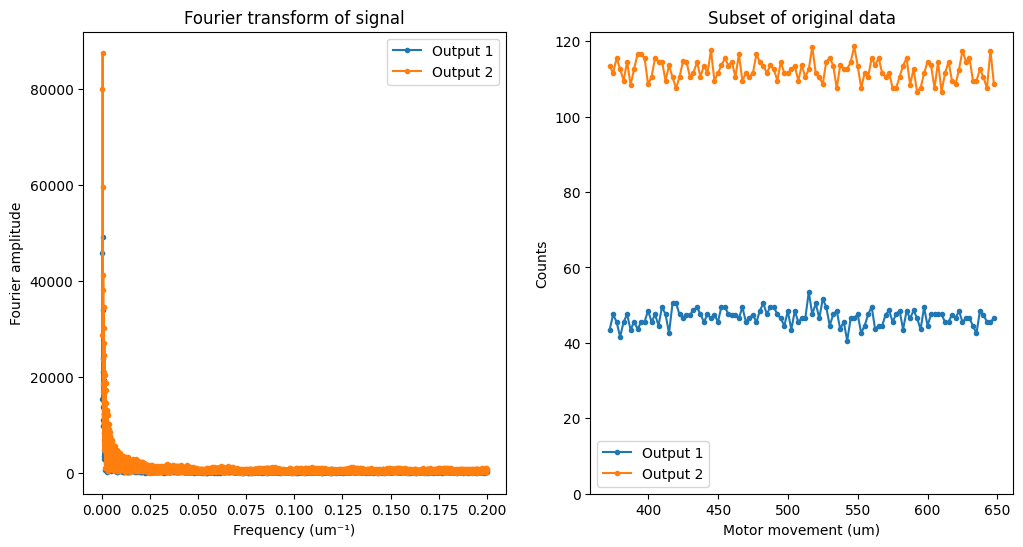

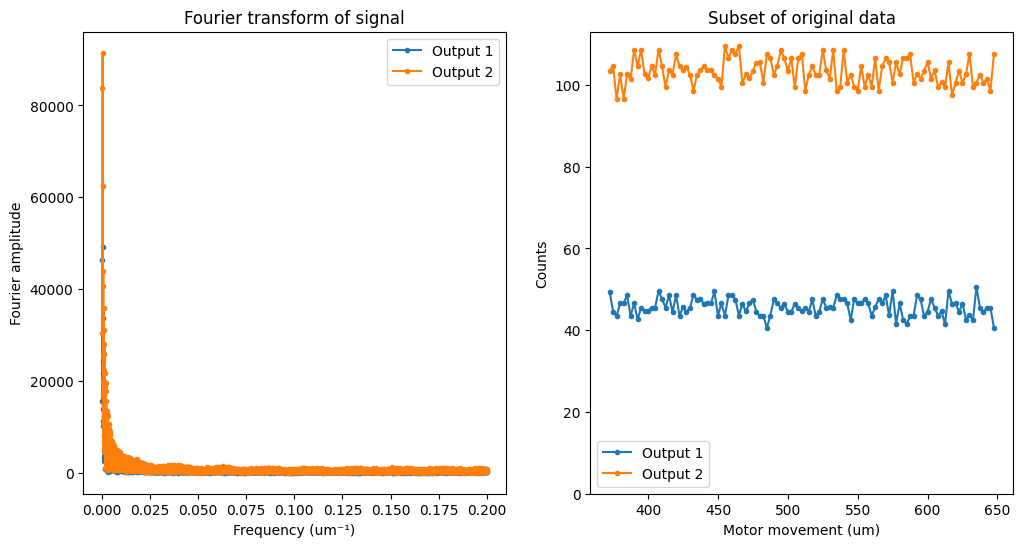

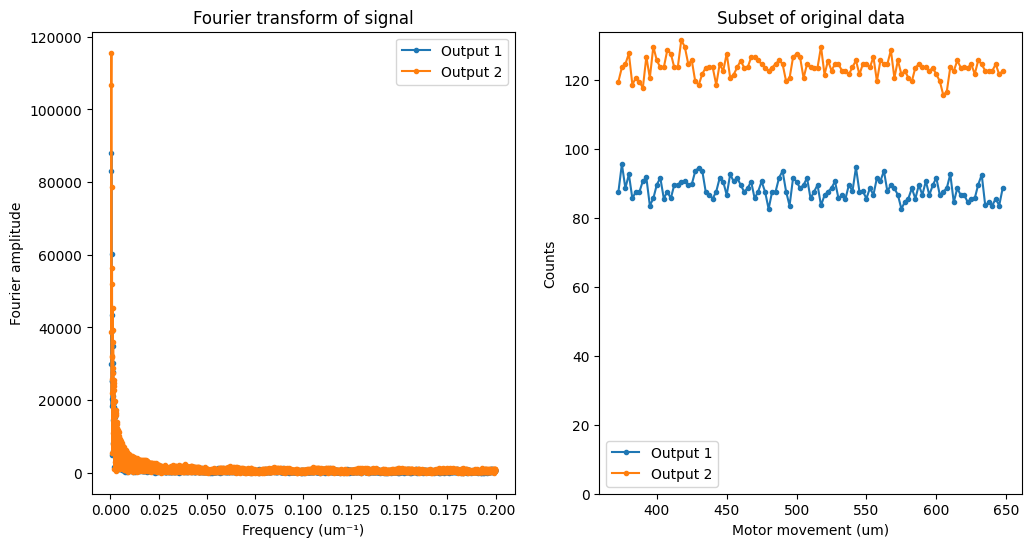

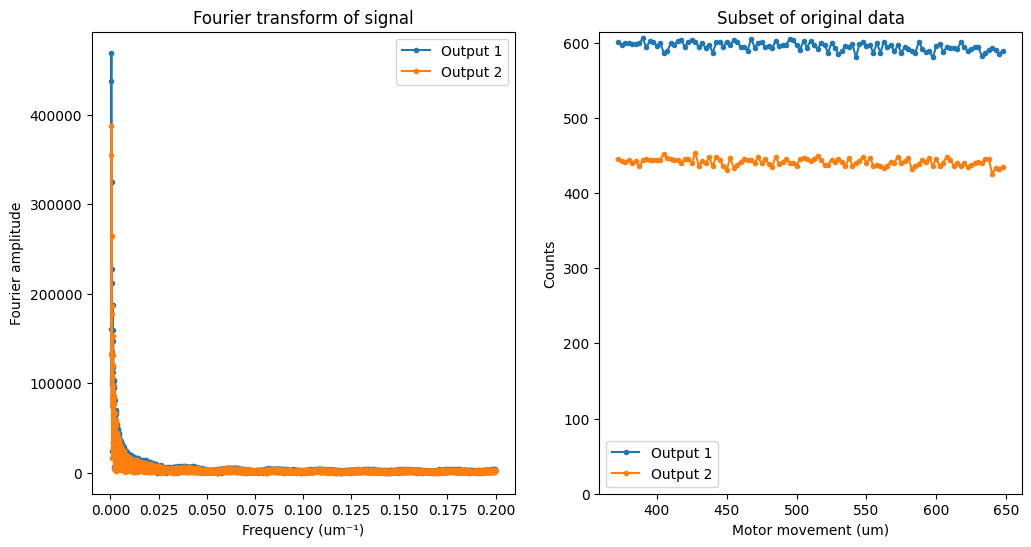

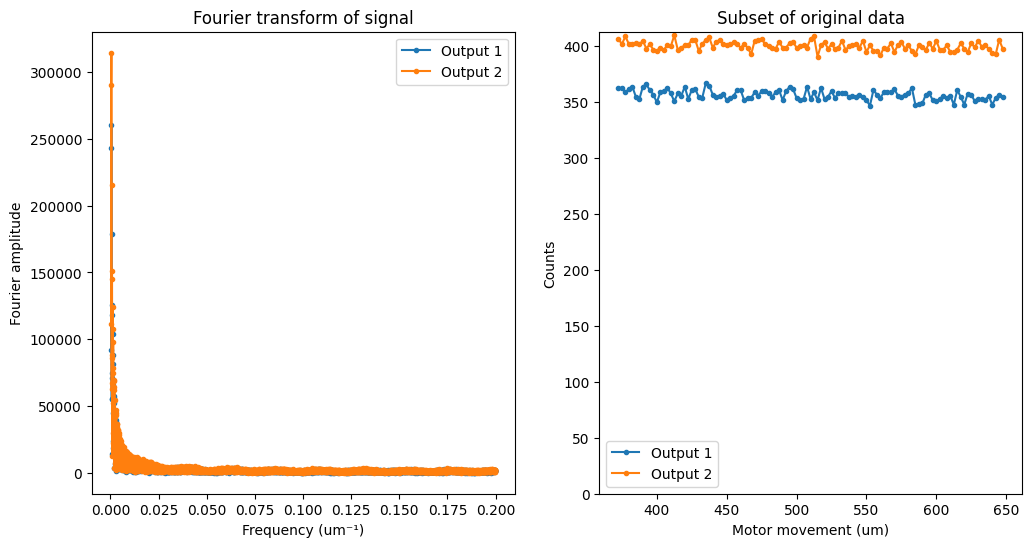

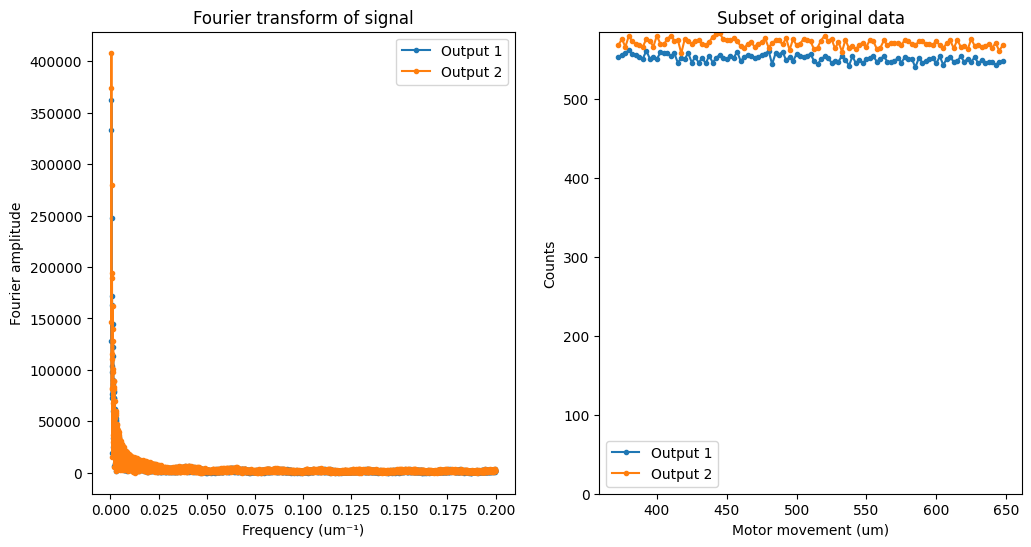

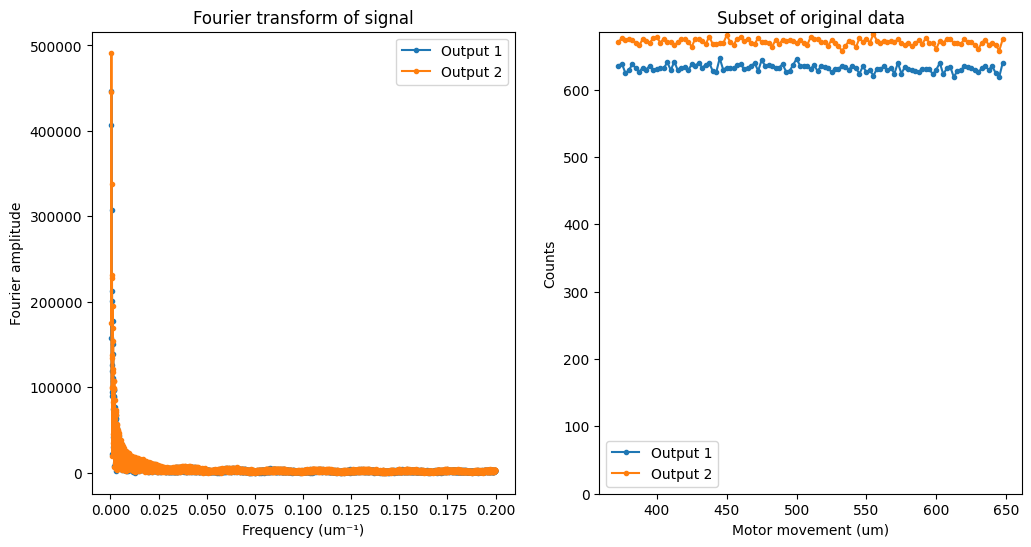

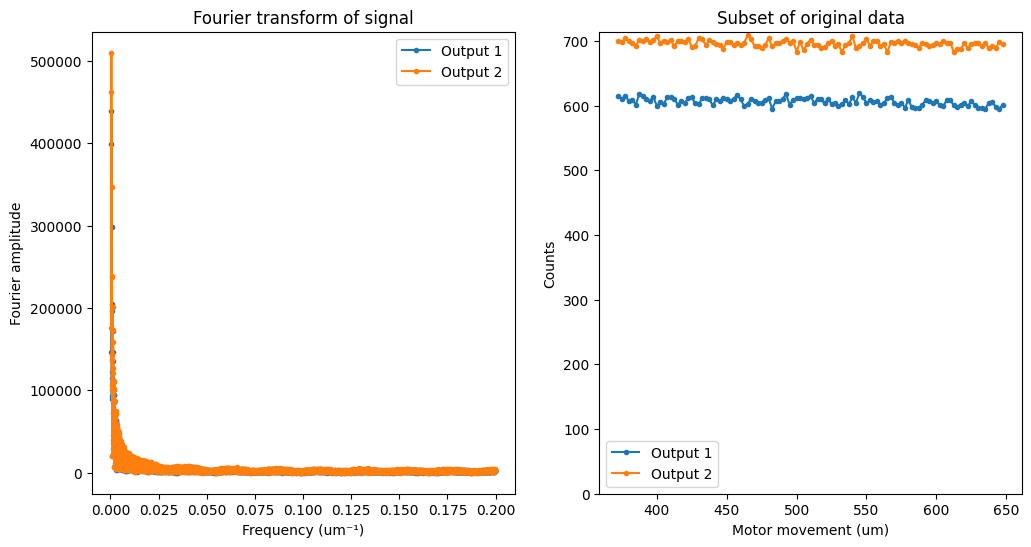

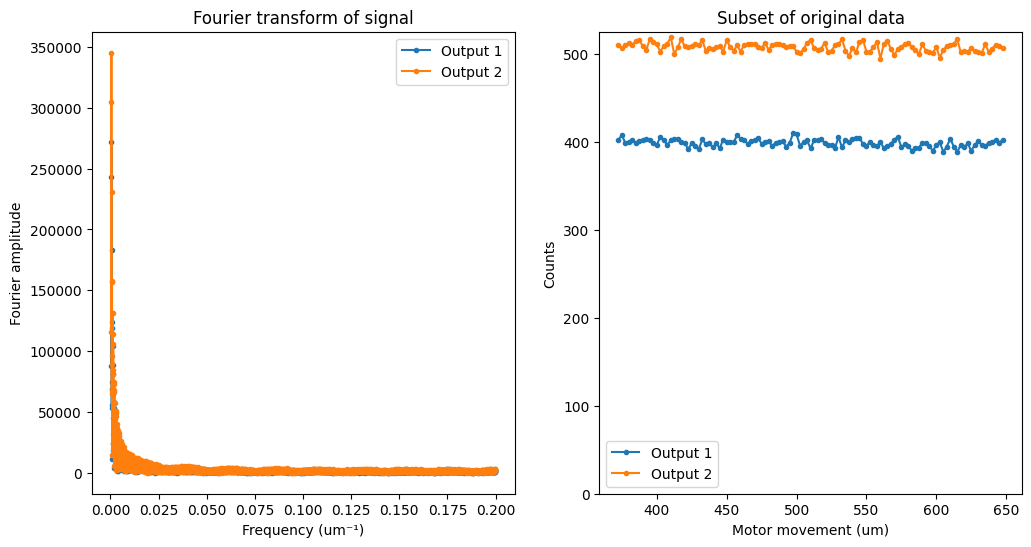

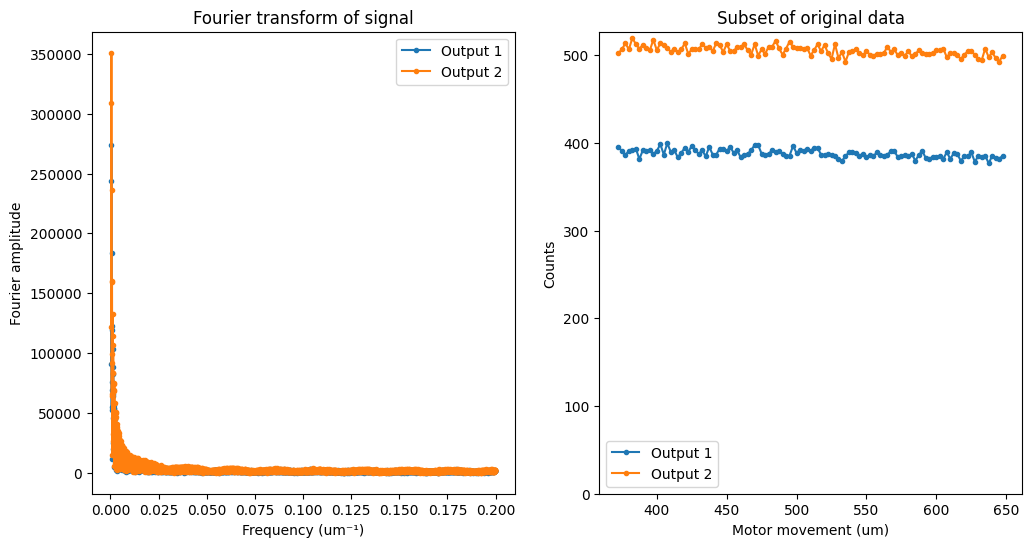

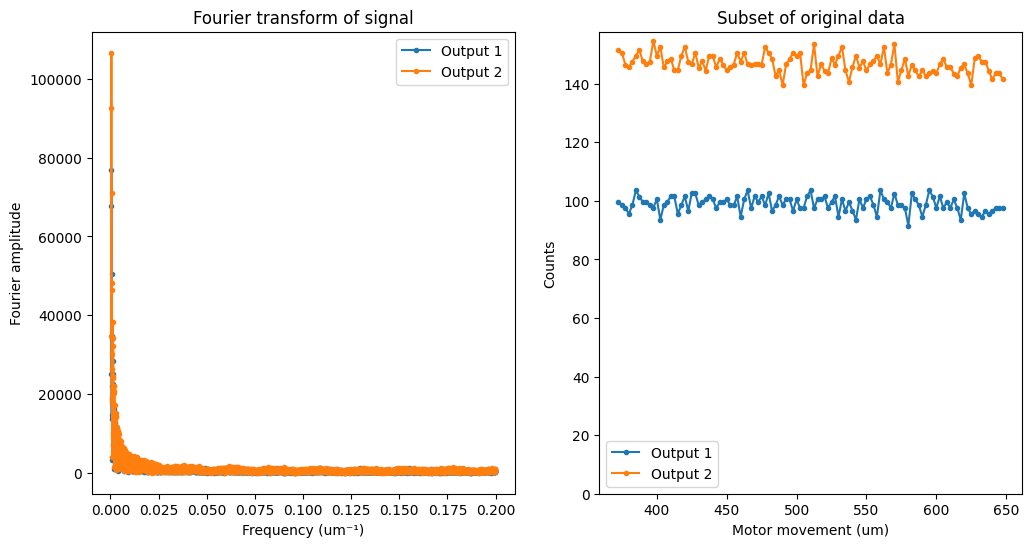

In [23]:
i_0 = 149
i_f = 260

o1_fourier_peaks = []
o2_fourier_peaks = []
for i, spot in spot_df.iloc[::2].iterrows():
    if i % graph_skip_n == 0:
        fig, ax = plt.subplots(ncols=2,figsize=(12,6))
    
    output_1 = spot_df.iloc[i]
    output_2 = spot_df.iloc[i+1]

    # Below plots the modulus of the fft values, and doesn't display points after the nyquist frequency
    if i % graph_skip_n == 0:
        ax[0].plot(frequencies[5:model_size//2], np.abs(output_1['fft_vals'][5:model_size//2]), marker='.', label='Output 1')
        ax[0].plot(frequencies[5:model_size//2], np.abs(output_2['fft_vals'][5:model_size//2]), marker='.', label='Output 2')
        #indexed to ignore the 0-spike

    #it graphs 
    o1_fourier_peaks.append( np.abs(output_1['fft_vals'][ output_1['fft_vals'][5:model_size//2].argmax() + 5 ]) )
    o2_fourier_peaks.append( np.abs(output_2['fft_vals'][ output_2['fft_vals'][5:model_size//2].argmax() + 5 ]) )

    #int_freq = find_int_freq(spot['wavelength(nm)'])
    #ax[0].axvline(x=int_freq, color='k', ls='--', label=f'Expected interference frequency at {int_freq:.3f} {time_div_label}⁻¹')

    if i % graph_skip_n == 0:
        ax[0].set_xlabel("Frequency (um⁻¹)")
        ax[0].set_ylabel("Fourier amplitude")
        ax[0].set_title(f"Fourier transform of signal")
        ax[0].legend()

    if i % graph_skip_n == 0:
        ax[1].plot(displacements[i_0:i_f], output_1['hist_vals'][i_0:i_f], marker='.', label=f"Output {output_1['output']}")
        ax[1].plot(displacements[i_0:i_f], output_2['hist_vals'][i_0:i_f], marker='.', label=f"Output {output_2['output']}")

        ax[1].set_ylim(bottom=0)

        ax[1].set_title(f"Subset of original data")
        ax[1].set_xlabel(f"Motor movement (um)")
        ax[1].set_ylabel("Counts")
        ax[1].legend()

        #fig.tight_layout()

#### Fourier transforms of visibilities

[0.0004     0.00106667 0.00046667 0.0004     0.0004     0.0004
 0.0004     0.0004     0.0004     0.0004     0.0004     0.0004
 0.00046667 0.0004     0.00033333 0.00046667 0.00046667 0.00046667
 0.00033333 0.00033333 0.00033333 0.00033333 0.00033333 0.00033333
 0.00033333 0.00033333 0.00033333 0.00033333 0.00033333 0.00033333
 0.00033333 0.00046667 0.00033333 0.00033333 0.00033333 0.00033333
 0.00033333 0.00033333 0.00046667 0.00046667 0.0004     0.0006
 0.0004     0.0004     0.0004     0.0004     0.0004     0.00066667
 0.0004     0.0004     0.0004     0.00053333 0.00046667 0.0004
 0.00046667]


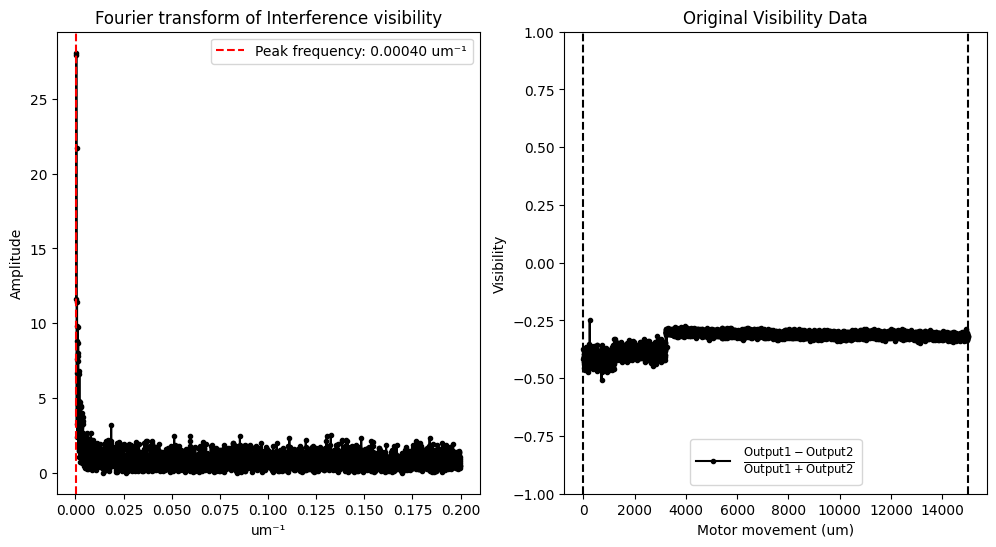

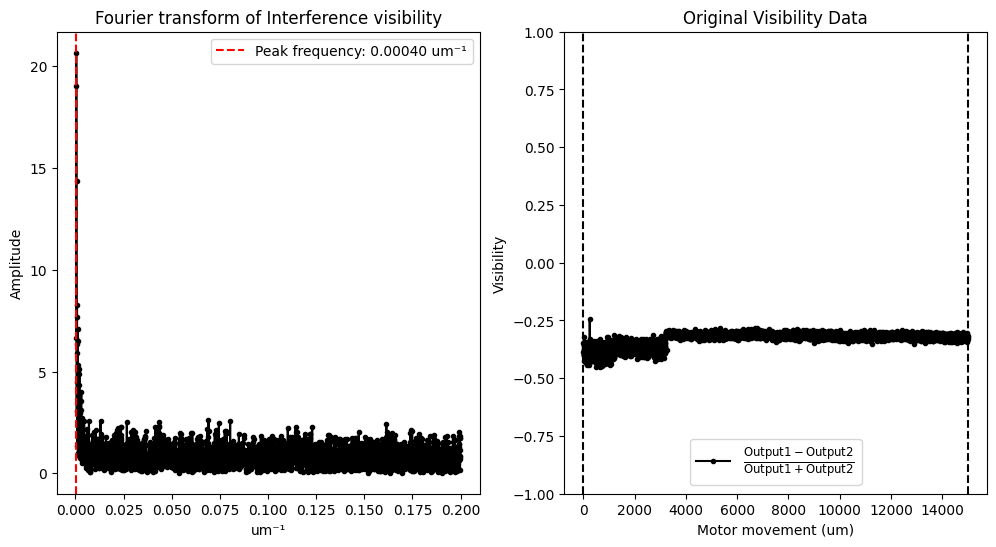

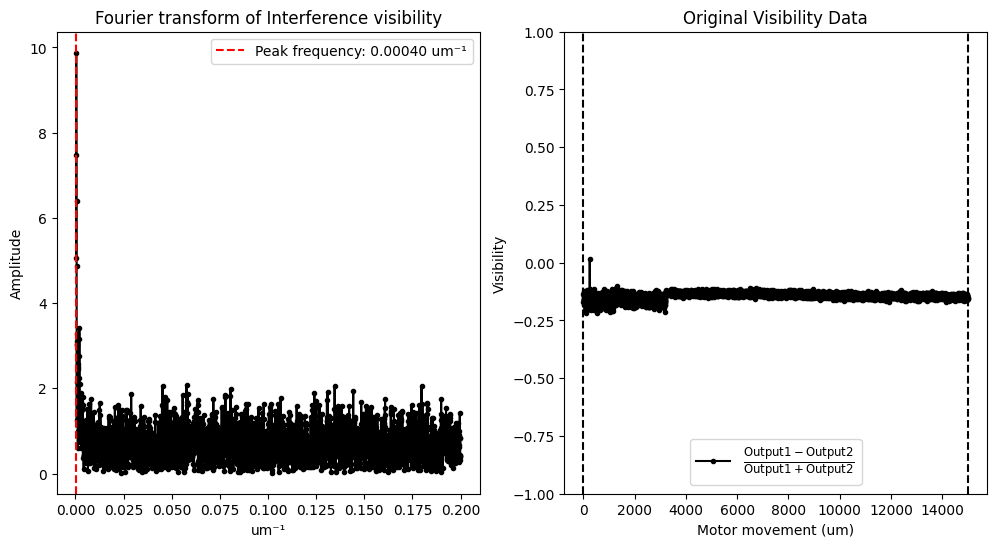

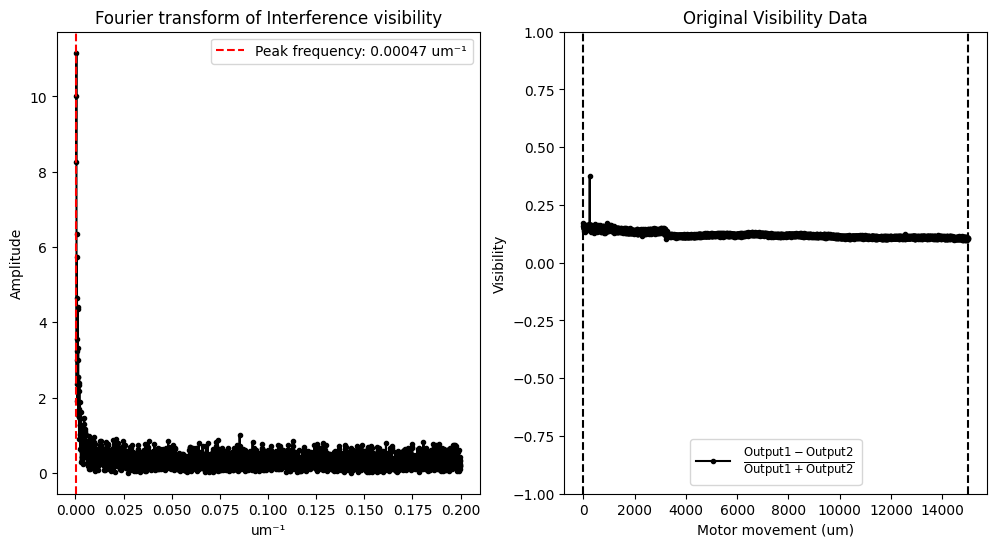

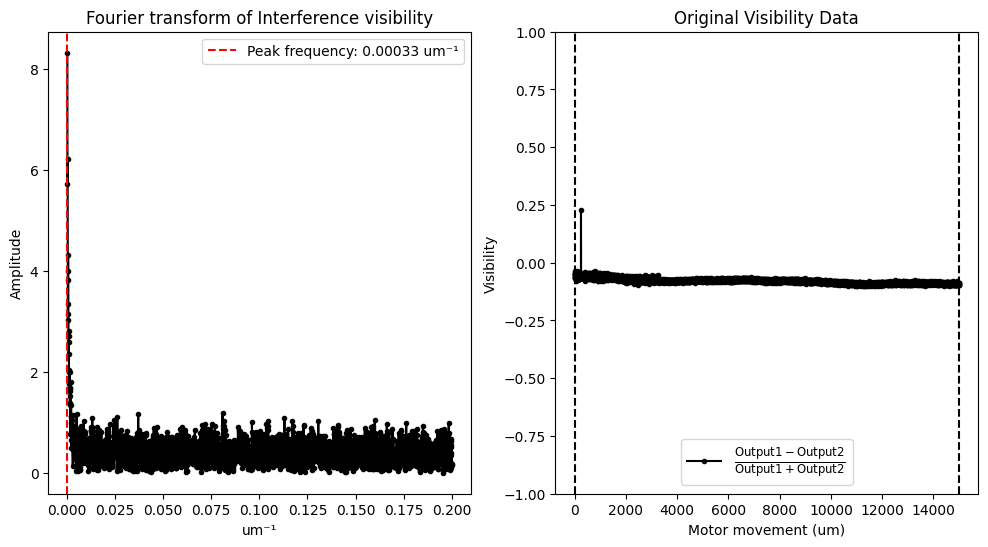

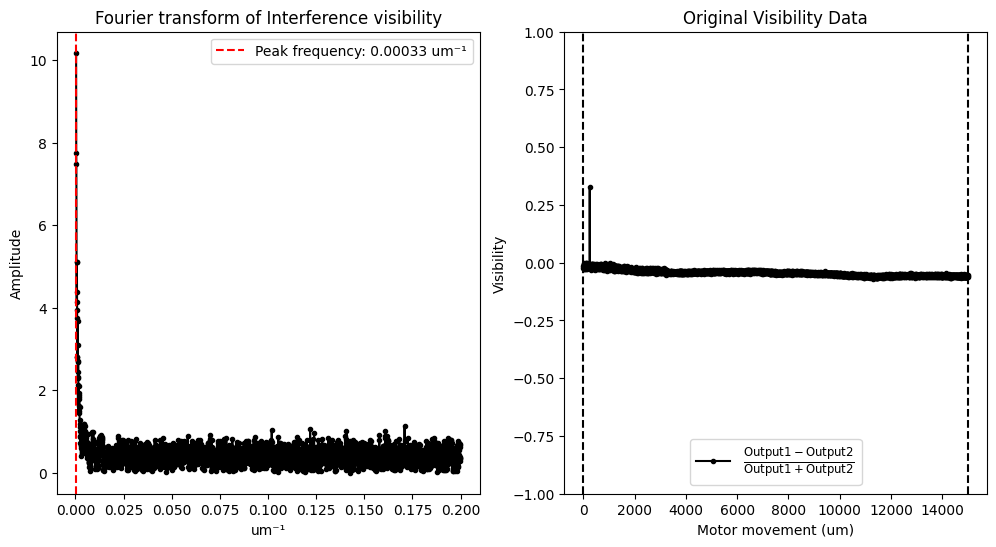

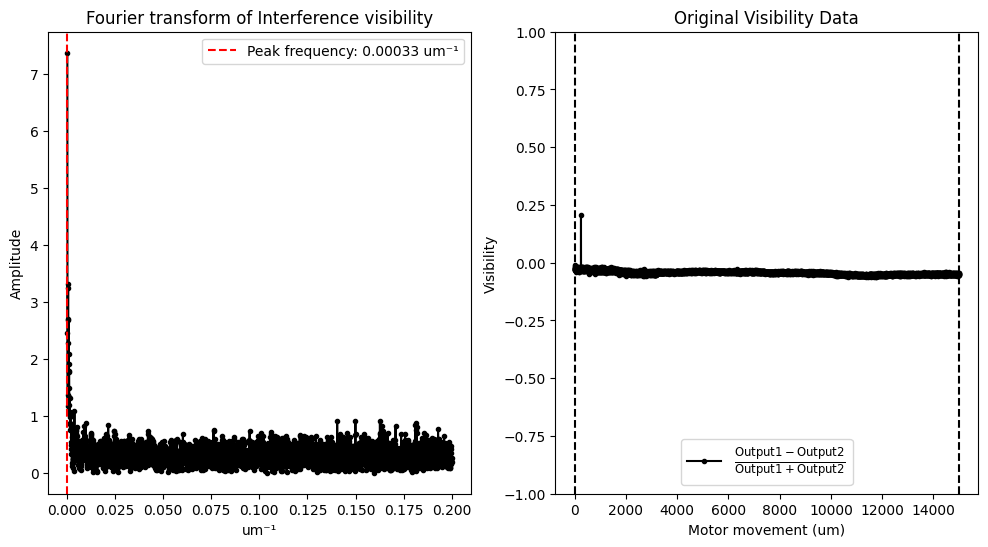

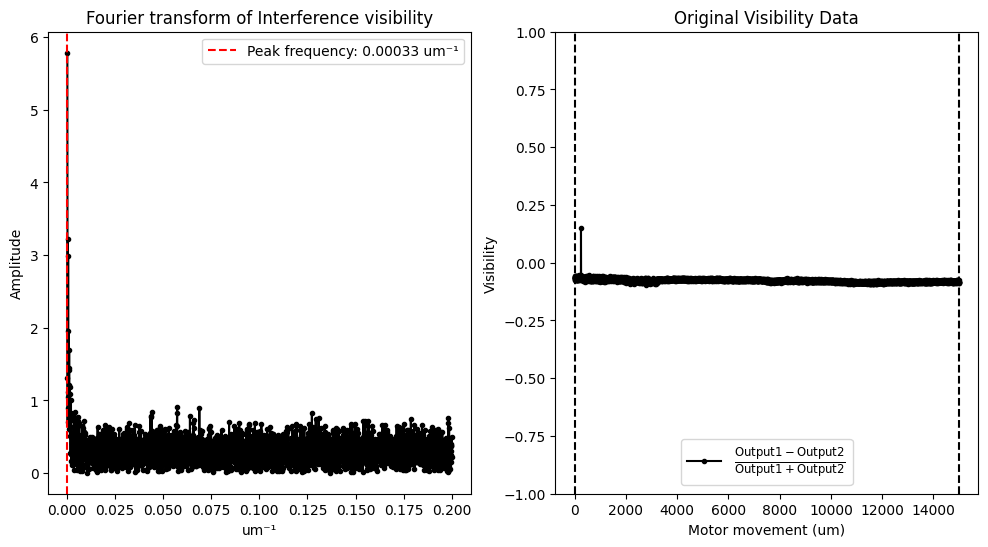

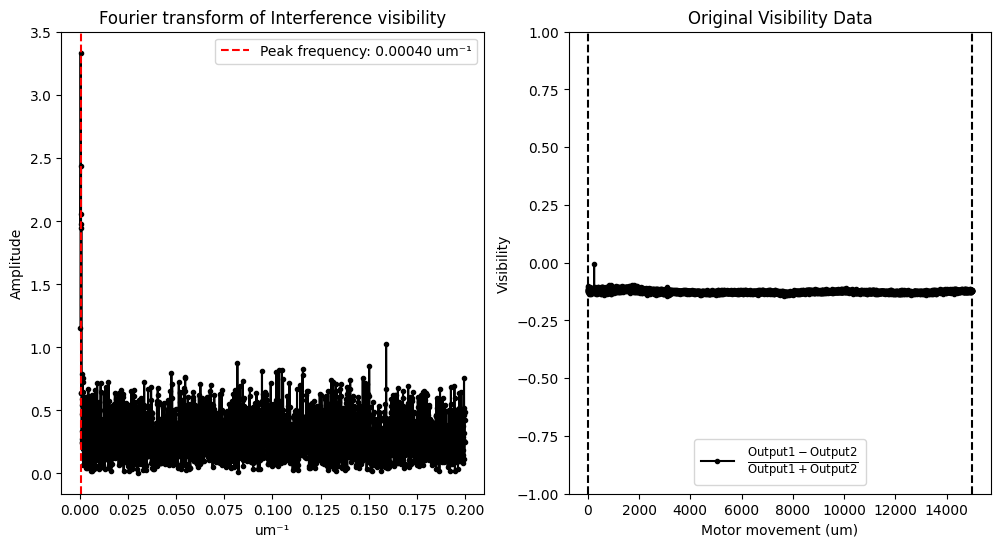

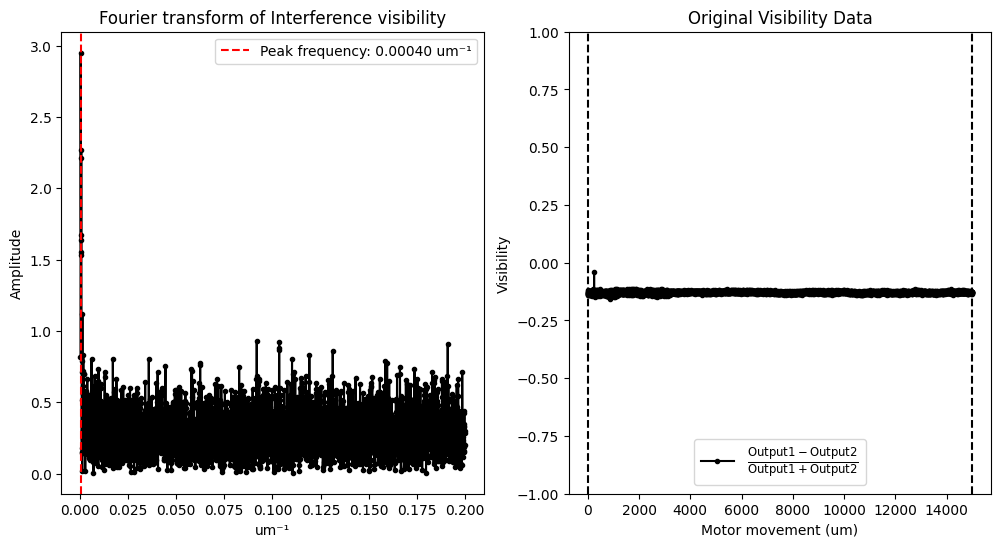

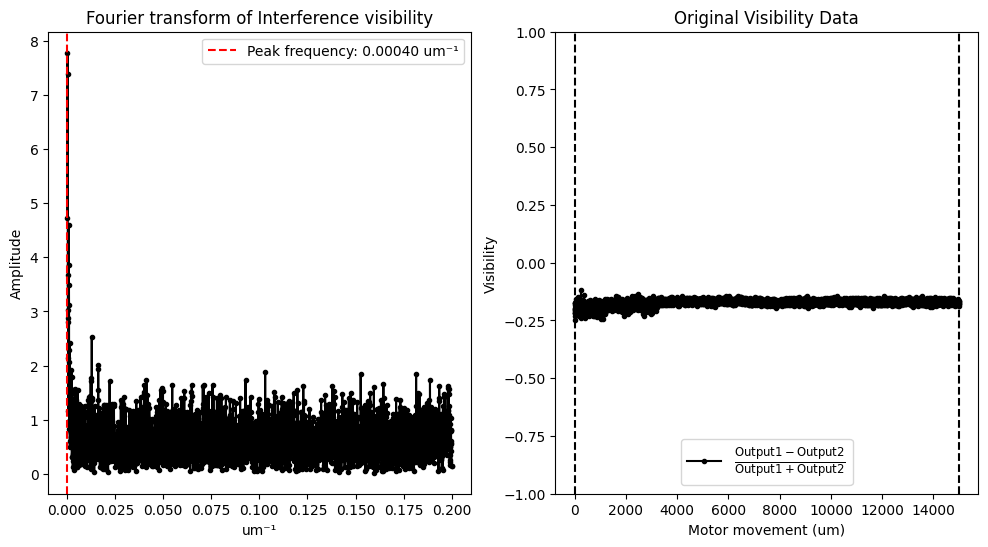

In [25]:
#exps = [] #expected fourier peaks, if we knew all the wavelengths
obss = []  #observed fourier peaks
#o1_fourier_peaks = []
#o2_fourier_peaks = []
vis_peaks = []
df = frequencies[4] - frequencies[3]
for i, spot in spot_df.iloc[::2].iterrows():
    if i % graph_skip_n == 0:
        fig, ax = plt.subplots(ncols=2,figsize=(12,6))

        # Below plots the modulus of the fft values, and doesn't display points after the nyquist frequency (negative values)
        ax[0].plot(frequencies[5:model_size//2], np.abs(spot['fft_vis_vals'][5:model_size//2]), marker='.', color=spot['display_color'])

    #finding the actual maximum value observed
    f_of_max_val = (np.abs(spot['fft_vis_vals'][5:model_size//2]).argmax() +5)* df
    obss.append(f_of_max_val)
    
    if i % graph_skip_n == 0:
        ax[0].axvline(x=f_of_max_val,color='red',ls='--',label=f'Peak frequency: {f_of_max_val:.5f} um⁻¹')

    vis_peaks.append( np.abs(spot['fft_vis_vals'][spot['fft_vis_vals'][5:model_size//2].argmax() +5]) )
    
    #plt.ylim(0, 25)
    if i % graph_skip_n == 0:
        ax[0].set_xlabel(f"um⁻¹")
        ax[0].set_ylabel("Amplitude")
        ax[0].set_title(f"Fourier transform of Interference visibility")
        ax[0].legend()

        # Time domain from before being modeled
        ax[1].plot(displacements[:numStays1], spot['vis_vals'], marker='.', color=spot['display_color'], 
                 label=r"$\mathrm{\frac{Output 1 - Output 2}{Output 1 + Output 2}}$")

        ax[1].axvline(x=model_start, color='k', ls='--')
        ax[1].axvline(x=model_end, color='k', ls='--')

        ax[1].set_ylim(-1, 1)

        ax[1].set_title(f"Original Visibility Data")
        ax[1].set_xlabel(f"Motor movement (um)")
        ax[1].set_ylabel("Visibility")
        ax[1].legend(fontsize='large')

print(np.array(obss))

In [26]:
#add max frequencies to spot_df
obs_doubled = [obss[i//2] for i in range(2*len(obss))]
spot_df['vis_freq_max(inv um)'] = obs_doubled
spot_df

,output,x_center,y_center,display_color,hist_vals,unc_vals,vis_vals,vis_uncs,fft_vals,fft_vis_vals,vis_freq_max(inv um)
0,1,1,1135.0,#000000,"[49.545, 46.5075, 41.46, 47.6, 46.487503, 48.5...","[0.7342066884801581, 0.7122842159614592, 0.675...","[-0.3732051449599472, -0.41871074746467996, -0...","[0.00701042872451626, 0.006824729543306031, 0....","[(1068097+0j), (-152544.16+82418.88j), (-49954...","[(-1965.9116415824278+0j), (-88.27138391443644...",0.000400
1,2,1,2035.0,#000000,"[108.545, 113.5075, 110.46, 111.6, 111.4875, 1...","[0.7342066884801581, 0.7122842159614592, 0.675...","[-0.3732051449599472, -0.41871074746467996, -0...","[0.00701042872451626, 0.006824729543306031, 0....","[(2055670+0j), (-261462.52+153247.78j), (-8299...","[(-1965.9116415824278+0j), (-88.27138391443644...",0.000400
2,1,101,1138.0,#000000,"[54.545, 47.5075, 53.46, 54.6, 50.487503, 52.5...","[0.7342066884801581, 0.7122842159614592, 0.675...","[0.11214191467709203, 0.03260338009997853, 0.0...","[0.01065178495054725, 0.010953184206163636, 0....","[(1298474+0j), (-189806.2+103114.79j), (-61902...","[(432.3353528519823+0j), (1.755526947126445-8....",0.001067
3,2,101,2037.0,#000000,"[43.545, 44.5075, 44.46, 43.6, 46.487503, 42.5...","[0.7342066884801581, 0.7122842159614592, 0.675...","[0.11214191467709203, 0.03260338009997853, 0.0...","[0.01065178495054725, 0.010953184206163636, 0....","[(1126210+0j), (-163203.25+92044.39j), (-53914...","[(432.3353528519823+0j), (1.755526947126445-8....",0.001067
4,1,201,1141.0,#000000,"[308.54498, 300.5075, 300.46, 299.6, 298.4875,...","[0.7342066884801581, 0.7122842159614592, 0.675...","[0.5011067995392781, 0.48760566861841614, 0.47...","[0.0028251651914705835, 0.002773887977390377, ...","[(5136078+0j), (-638750.94+363784.94j), (-2041...","[(2485.6935744787575+0j), (72.81745760992544-5...",0.000467
...,...,...,...,...,...,...,...,...,...,...,...
105,2,5201,2155.0,#000000,"[35.545, 31.5075, 31.46, 28.599998, 34.487503,...","[0.7342066884801581, 0.7122842159614592, 0.675...","[-0.9697978263093852, -0.7996573036719145, -0....","[0.04007782969039322, 0.036835241557129764, 0....","[(714766+0j), (-104336.39+57998.43j), (-30029....","[(-4120.754120838126+0j), (-142.4181088377162+...",0.000467
106,1,5301,1298.0,#000000,"[125.545, 130.5075, 129.45999, 130.6, 128.4875...","[0.7342066884801581, 0.7122842159614592, 0.675...","[-0.2616954363796563, -0.2627007221497532, -0....","[0.003155902594254376, 0.0029419674239413974, ...","[(2310366+0j), (-289923.66+160070.66j), (-9371...","[(-1436.8414027723472+0j), (-14.61295321446556...",0.000400
107,2,5301,2157.0,#000000,"[214.545, 223.5075, 219.45999, 223.6, 223.4875...","[0.7342066884801581, 0.7122842159614592, 0.675...","[-0.2616954363796563, -0.2627007221497532, -0....","[0.003155902594254376, 0.0029419674239413974, ...","[(3749608+0j), (-462202.66+262850.5j), (-15131...","[(-1436.8414027723472+0j), (-14.61295321446556...",0.000400
108,1,5401,1301.0,#000000,"[184.545, 179.5075, 182.45999, 182.6, 185.4875...","[0.7342066884801581, 0.7122842159614592, 0.675...","[-0.19778736439289177, -0.19325190649564963, -...","[0.002300506035322523, 0.0023054490840464085, ...","[(3113357+0j), (-384765.44+211777.14j), (-1254...","[(-1134.7870193885701+0j), (-4.719065190234073...",0.000467


#### Save spot_csv and displacements

In [18]:
#FIXME: This doesn't transfer over the lists in the above csv.
# It'd be nice (not strictly necessary) to do that. Perhaps using a really big dataframe.
spot_df.to_csv('f25A_HgXe/spot_csv_ASI183_f25A.csv')

In [40]:
np.save("f25A_HgXe/displacements_f25A", displacements)

### Discussion

The Fourier transforms can't pick anything up (they all erally only maximize at the artefact 0), so I'm gonna go ahead and call it here.